In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('movies.txt', 'r', encoding='utf-8').read().splitlines()
words[:10]

['Toy Story',
 'Jumanji',
 'Grumpier Old Men',
 'Waiting to Exhale',
 'Father of the Bride Part II',
 'Heat',
 'Sabrina',
 'Tom and Huck',
 'Sudden Death',
 'GoldenEye']

In [3]:
len(words)

42259

In [4]:
import unicodedata
import re

def clean(word):
    word = unicodedata.normalize('NFKD', word)
    word = word.lower()
    # Keep lowercase letters, digits, spaces, apostrophes, hyphens
    word = re.sub(r"[^a-z0-9 '\-]", '', word)
    return word.strip()

In [5]:
chars = sorted(list(set(''.join(words))))
print(chars)

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '¡', '¢', '£', 'ª', '°', '²', '³', '·', '½', '¿', 'À', 'Á', 'Â', 'Å', 'Æ', 'Ç', 'È', 'É', 'Ö', '×', 'Ú', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ë', 'ì', 'í', 'î', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ù', 'ú', 'û', 'ü', 'ā', 'ą', 'Ć', 'ć', 'ē', 'ę', 'ě', 'ğ', 'İ', 'ı', 'ł', 'ń', 'ņ', 'œ', 'ś', 'Ş', 'ş', 'Š', 'š', 'ū', 'ů', 'ż', 'Ž', 'ž', 'Α', 'Β', 'Γ', 'Δ', 'Θ', 'Κ', 'Λ', 'Μ', 'Ν', 'Ξ', 'Ο', 'Π', 'Σ', 'Τ', 'Υ', 'Φ', 'ά', 'έ', 'ή', 'ί', 'α', 'γ', 'δ', 'ε', 'η', 'ι', 'κ', 'λ', 'μ', 'ν', 'ο', 'π', 'ρ', 'ς', 'σ', 'τ', 'υ', 'φ', 'χ',

In [6]:
# cleaned_words = [clean(w) for w in words if w.strip() != '']
cleaned_words = [clean(w) for w in words if clean(w).strip() != '']

In [7]:
chars = sorted(list(set(''.join(cleaned_words))))

In [8]:
chars

[' ',
 "'",
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [14]:
chars = sorted(list(set(''.join(cleaned_words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [15]:
stoi

{' ': 1,
 "'": 2,
 '-': 3,
 '0': 4,
 '1': 5,
 '2': 6,
 '3': 7,
 '4': 8,
 '5': 9,
 '6': 10,
 '7': 11,
 '8': 12,
 '9': 13,
 'a': 14,
 'b': 15,
 'c': 16,
 'd': 17,
 'e': 18,
 'f': 19,
 'g': 20,
 'h': 21,
 'i': 22,
 'j': 23,
 'k': 24,
 'l': 25,
 'm': 26,
 'n': 27,
 'o': 28,
 'p': 29,
 'q': 30,
 'r': 31,
 's': 32,
 't': 33,
 'u': 34,
 'v': 35,
 'w': 36,
 'x': 37,
 'y': 38,
 'z': 39,
 '.': 0}

In [16]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(cleaned_words):  
  X, Y = [], []
  
  for w in cleaned_words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(cleaned_words)
n1 = int(0.8*len(cleaned_words))
n2 = int(0.9*len(cleaned_words))

Xtr,  Ytr  = build_dataset(cleaned_words[:n1])     # 80%
Xdev, Ydev = build_dataset(cleaned_words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(cleaned_words[n2:])     # 10%

torch.Size([607647, 3]) torch.Size([607647])
torch.Size([74982, 3]) torch.Size([74982])
torch.Size([74922, 3]) torch.Size([74922])


In [17]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

14840


In [18]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/ 200000: 3.6858
  10000/ 200000: 2.5165
  20000/ 200000: 2.2760
  30000/ 200000: 1.8737
  40000/ 200000: 1.8522
  50000/ 200000: 2.3178
  60000/ 200000: 1.8413
  70000/ 200000: 1.8458
  80000/ 200000: 2.1764
  90000/ 200000: 2.5882
 100000/ 200000: 1.9780
 110000/ 200000: 1.7481
 120000/ 200000: 2.0927
 130000/ 200000: 1.6783
 140000/ 200000: 2.0069
 150000/ 200000: 1.7314
 160000/ 200000: 1.8965
 170000/ 200000: 2.4108
 180000/ 200000: 2.1619
 190000/ 200000: 2.1026


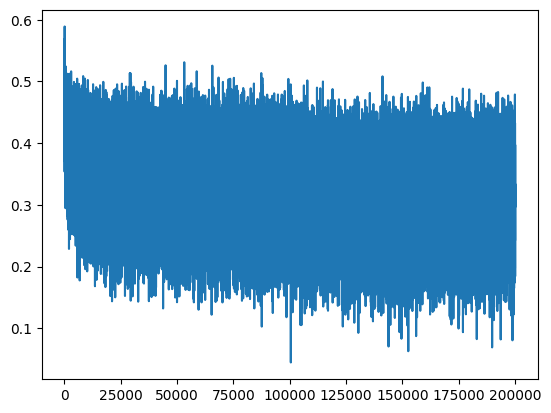

In [19]:
plt.plot(lossi)

In [20]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [21]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.01357102394104
val 2.0267274379730225


In [22]:
# SUMMARY + PYTORCHIFYING -----------

In [23]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

48480


In [24]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.7174


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.59%
layer 5 (      Tanh): mean -0.01, std 0.64, saturated: 2.84%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 2.22%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 2.03%


Text(0.5, 1.0, 'activation distribution')

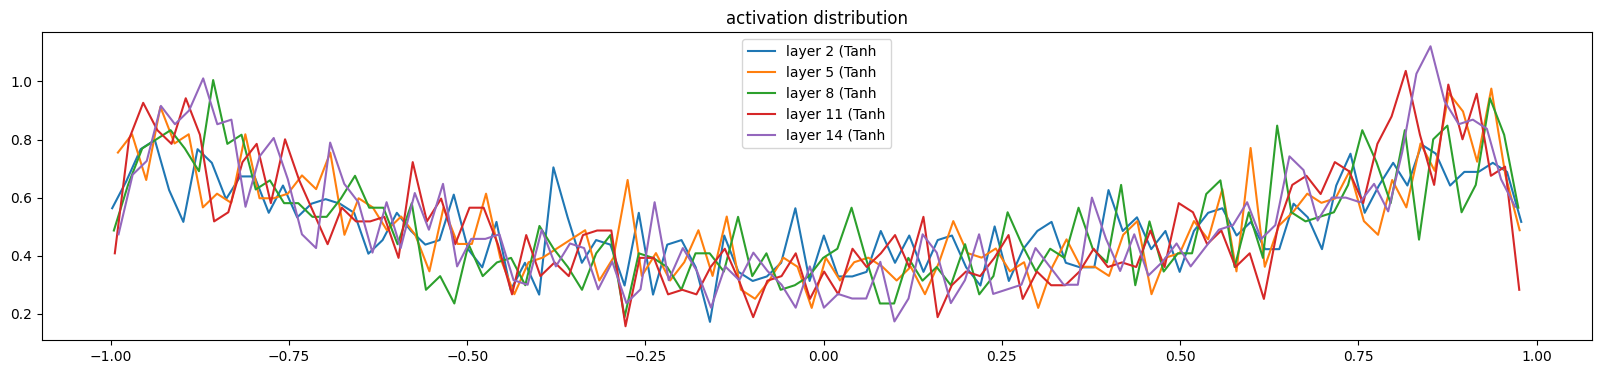

In [25]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 3.015951e-03
layer 5 (      Tanh): mean +0.000000, std 2.697856e-03
layer 8 (      Tanh): mean -0.000000, std 2.581652e-03
layer 11 (      Tanh): mean -0.000000, std 2.518804e-03
layer 14 (      Tanh): mean -0.000000, std 2.546922e-03


Text(0.5, 1.0, 'gradient distribution')

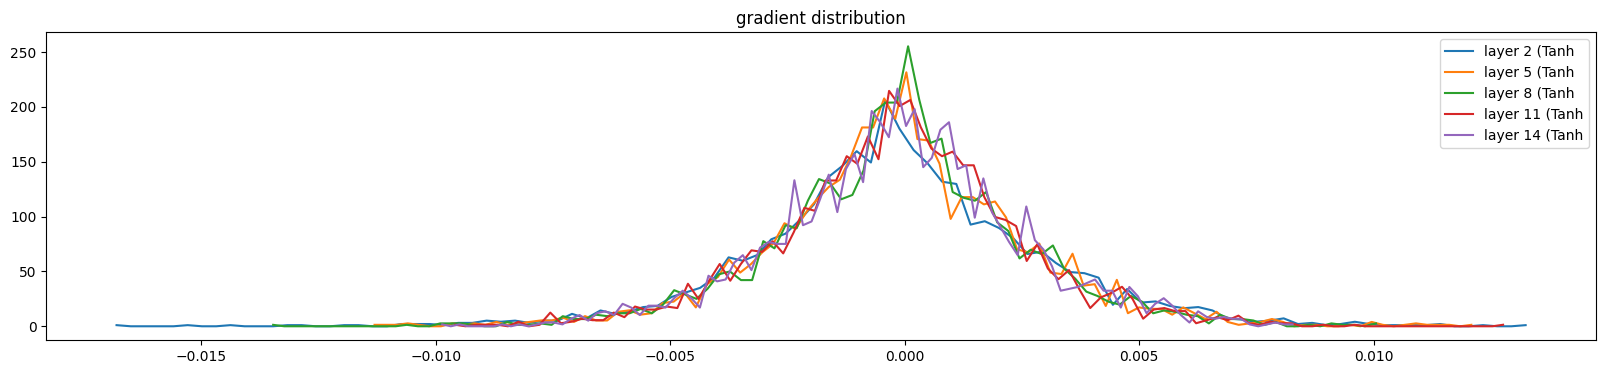

In [26]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (40, 10) | mean -0.000000 | std 8.284112e-03 | grad:data ratio 8.503623e-03
weight  (30, 100) | mean -0.000166 | std 1.216124e-02 | grad:data ratio 6.438522e-02
weight (100, 100) | mean +0.000083 | std 8.810759e-03 | grad:data ratio 8.489632e-02
weight (100, 100) | mean -0.000005 | std 8.078484e-03 | grad:data ratio 7.871505e-02
weight (100, 100) | mean -0.000028 | std 7.649993e-03 | grad:data ratio 7.473945e-02
weight (100, 100) | mean +0.000035 | std 7.349357e-03 | grad:data ratio 7.141433e-02
weight  (100, 40) | mean +0.000015 | std 1.272681e-02 | grad:data ratio 1.213715e-01


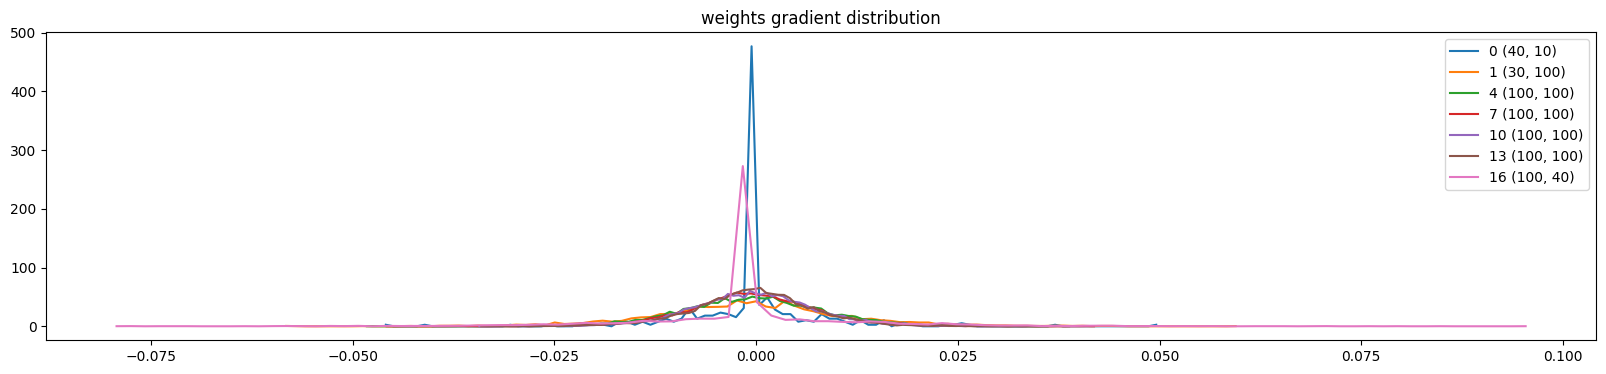

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

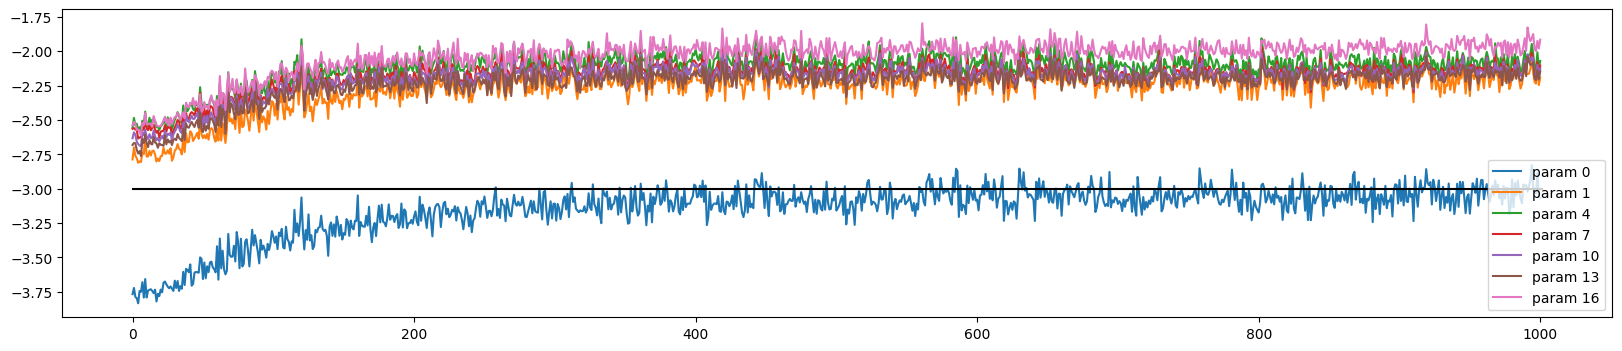

In [28]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [29]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.497277021408081
val 2.4913077354431152


In [30]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

ter il9l masm1es.
the ving the graxeanu.
parn 0ov85hentcoethe s1akide a eanclingers paa.
fetsie3tinetnne.
grie.
goldrkatch ofhrrpar0 elledhte 4ile last sal in4 man slveshach rouidhe ali.
the ia bparcencke2dakblbollncrny fewg llin4here.
in vilro.
the oji8 alpegqerlighan3l5 in stey ukinx piry.
oratew1 veadesk ir thep the s3l of irhpa.
5y.
vet4eire8dx samec alabngeecoe ind ne3inathg.
theate slacpel3abnxs jassmawesirt96-eghat xan.
6stjn tanqewtoing und'r1o.
-e orimascul4ong ss 3bize the -o cabo cbotogacast0o4 tu.
kapastens oungelvin.
the co.
-aste anmaro.
de.
9zeu jo.
